In [ ]:
pip install accelerate -U

In [ ]:
!pip install transformers torch datasets scikit-learn numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from datasets import load_dataset

# Assuming the data is in a CSV file
dataset_path = 'preprocessed_dataset.csv'
dataset = load_dataset('csv', data_files={'data': dataset_path})

print(dataset)



Generating data split: 0 examples [00:00, ? examples/s]

DatasetDict({
    data: Dataset({
        features: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'name', 'retweet_count', 'text', 'tweet_created', 'processed_text'],
        num_rows: 14640
    })
})


In [ ]:
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

def label_to_number(example):
    example['airline_sentiment'] = label_mapping[example['airline_sentiment']]
    return example

dataset = dataset.map(label_to_number)


Map:   0%|          | 0/14640 [00:00<?, ? examples/s]

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_and_format(examples):
    # Tokenize the text
    tokenized_inputs = tokenizer(examples['text'], truncation=True, padding="max_length", max_length=128)
    # Include labels
    tokenized_inputs['labels'] = examples['airline_sentiment']
    return tokenized_inputs

dataset = dataset.map(tokenize_and_format, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/14640 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset['data'].train_test_split(test_size=0.2)


In [ ]:
from transformers import BertForSequenceClassification

# Load the BERT model, the pretrained BERT base model will be adapted for sequence classification with three labels
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import EvalPrediction
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    label_ids = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(label_ids, preds, average='weighted')
    acc = accuracy_score(label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # Directory where the model predictions and checkpoints will be written
    num_train_epochs=3,              # Total number of training epochs
    per_device_train_batch_size=8,   # Batch size per device during training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.02,               # Weight decay if applied
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=50,                # Log every x updates steps
    evaluation_strategy="steps",     # Evaluate the model at the end of each epoch
    eval_steps=100,
    save_strategy="steps",           # Save the model at the end of each epoch
    save_steps=100,
    load_best_model_at_end=True,     # Load the best model when finished training (based on evaluation)
    learning_rate=3e-5,

)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics
)


In [ ]:
# Start training
trainer.train()

# Optionally, save the model manually if needed (Trainer saves automatically if configured)
# model.save_pretrained('./saved_model')

evaluation_results = trainer.evaluate()
print("Evaluation Results:", evaluation_results)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.728500,0.449700,0.837090,0.834358,0.833259,0.837090
2,0.237600,0.573085,0.850410,0.846420,0.845422,0.850410
3,0.128700,0.715271,0.846995,0.846057,0.845350,0.846995


Evaluation Results: {'eval_loss': 0.44969984889030457, 'eval_accuracy': 0.8370901639344263, 'eval_f1': 0.8343583608094978, 'eval_precision': 0.8332590689317849, 'eval_recall': 0.8370901639344263, 'eval_runtime': 23.2281, 'eval_samples_per_second': 126.054, 'eval_steps_per_second': 7.878, 'epoch': 3.0}


**Classifying the negative reason for the records with airline_sentiment as negative**

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('csv', data_files={'data': 'preprocessed_dataset.csv'})

# Access the dataset using the correct key
data_dataset = dataset['data']

# # Print the column names to confirm the structure
# print(data_dataset.column_names)

# # Now you can proceed to manipulate the dataset
# # Example: Inspecting the first few entries of a specific column
# print(data_dataset['airline_sentiment'][:5])



Generating data split: 0 examples [00:00, ? examples/s]

In [ ]:
from collections import Counter
# Filter the dataset for only negative sentiments
negative_dataset = data_dataset.filter(lambda example: example['airline_sentiment'] == 'negative')

# Extract 'negativereason' and count occurrences
reason_counts = Counter([entry['negativereason'] for entry in negative_dataset if 'negativereason' in entry])



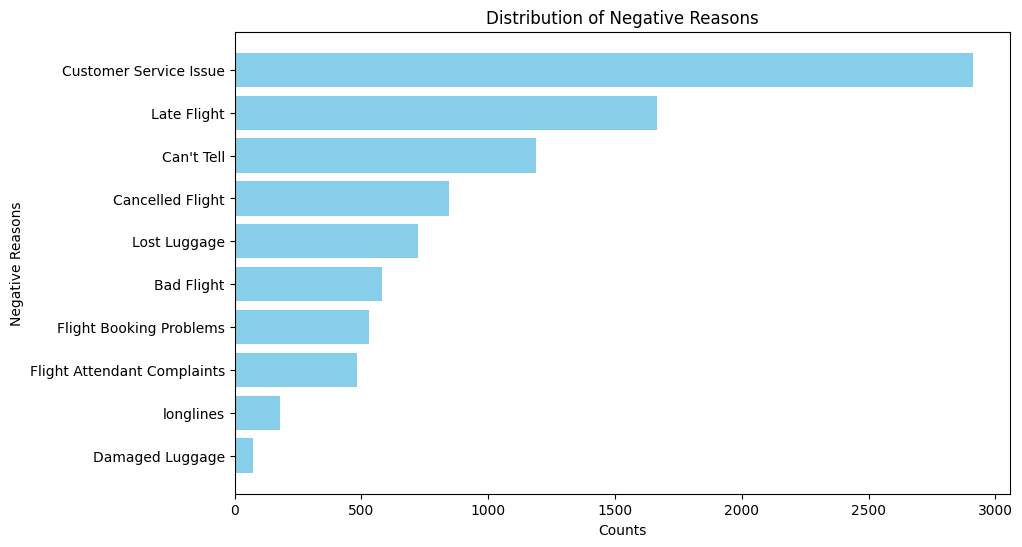

In [ ]:
# Plotting the counts with a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.barh(reasons, counts, color='skyblue')  # Use barh for horizontal bars
plt.title('Distribution of Negative Reasons')
plt.xlabel('Counts')  # Now counts are on the x-axis
plt.ylabel('Negative Reasons')  # Reasons are on the y-axis
plt.gca().invert_yaxis()  # Ensure the highest value is on top if matplotlib doesn't automatically
plt.show()

In [ ]:


# Define a function to convert reasons to numeric labels
unique_reasons = set(negative_dataset['negativereason'])
reason_label_mapping = {reason: idx for idx, reason in enumerate(unique_reasons)}

def map_reason_labels(example):
    example['negativereason'] = reason_label_mapping[example['negativereason']]
    return example

# Apply the mapping function
negative_dataset = negative_dataset.map(map_reason_labels)


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Function to tokenize and include labels
def tokenize_and_include_labels(examples):
    tokenized_inputs = tokenizer(examples['processed_text'], truncation=True, padding="max_length", max_length=128)
    tokenized_inputs['labels'] = examples['negativereason']  # Make sure this column exists and is correctly named
    return tokenized_inputs

# Apply tokenization and include labels
negative_dataset = negative_dataset.map(tokenize_and_include_labels, batched=True)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/9178 [00:00<?, ? examples/s]

In [ ]:
# Ensure the train/test split is prepared with labels
train_test_split = negative_dataset.train_test_split(test_size=0.2)

In [ ]:
from transformers import EvalPrediction
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    label_ids = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(label_ids, preds, average='weighted')
    acc = accuracy_score(label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(reason_label_mapping))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,                      # Number of warmup steps for learning rate scheduler
    weight_decay=0.02,                     # Weight decay if applied
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    logging_strategy="epoch",     # Log at the end of each epoch
    save_strategy="epoch",        # Save at the end of each epoch
    load_best_model_at_end=True,
    metric_for_best_model='loss',
    greater_is_better=False,
    report_to="all"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_split['train'],
    eval_dataset=train_test_split['test'],
    compute_metrics=compute_metrics
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Start training
trainer.train()

# Evaluate the model
evaluation_results = trainer.evaluate()
print("Evaluation Results:", evaluation_results)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.498100,1.215277,0.618192,0.602314,0.601478,0.618192
2,0.998100,1.111071,0.633442,0.623519,0.624198,0.633442
3,0.623000,1.204492,0.645969,0.639460,0.637243,0.645969


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Results: {'eval_loss': 1.1110707521438599, 'eval_accuracy': 0.633442265795207, 'eval_f1': 0.6235189496535503, 'eval_precision': 0.6241984546723383, 'eval_recall': 0.633442265795207, 'eval_runtime': 14.1143, 'eval_samples_per_second': 130.081, 'eval_steps_per_second': 8.148, 'epoch': 3.0}


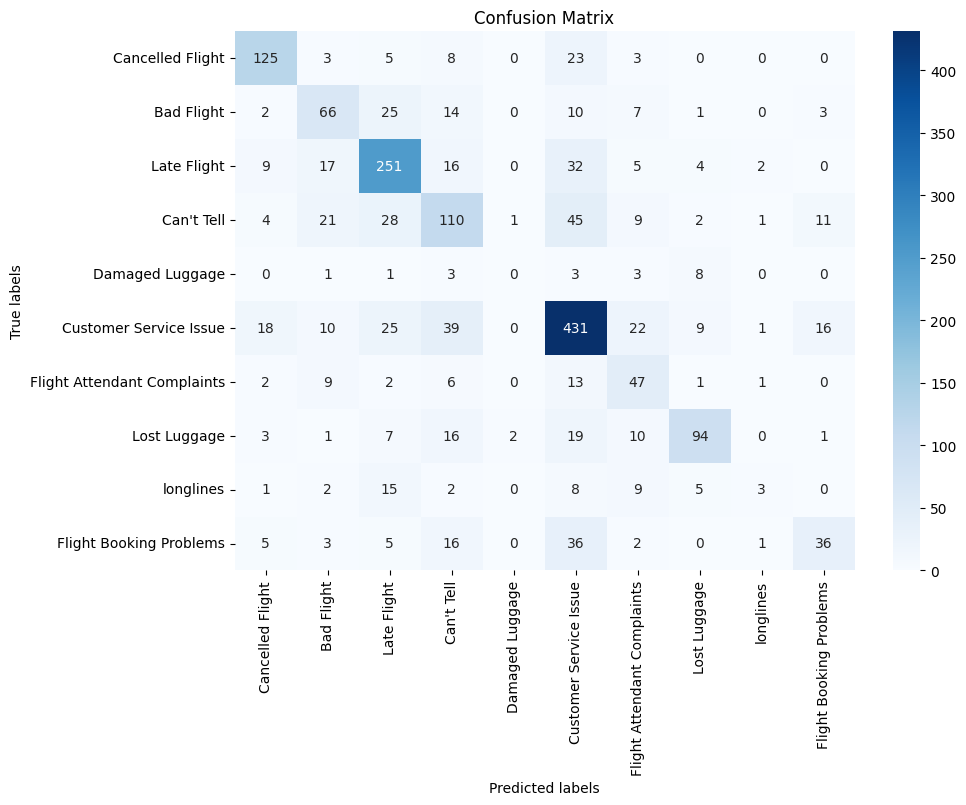

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Evaluate the model to get the final summary
evaluation_output = trainer.evaluate()

# Prediction to get the labels and predictions for the confusion matrix
predictions = trainer.predict(train_test_split['test'])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=reason_label_mapping.keys(), yticklabels=reason_label_mapping.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(trainer.state.log_history[:10])  # Print the first 10 entries to check their structure


[{'loss': 1.4981, 'grad_norm': 15.757946014404297, 'learning_rate': 4.0727595385980486e-05, 'epoch': 1.0, 'step': 918}, {'eval_loss': 1.2152771949768066, 'eval_accuracy': 0.6181917211328976, 'eval_f1': 0.602314317788962, 'eval_precision': 0.6014781468417169, 'eval_recall': 0.6181917211328976, 'eval_runtime': 14.1146, 'eval_samples_per_second': 130.078, 'eval_steps_per_second': 8.148, 'epoch': 1.0, 'step': 918}, {'loss': 0.9981, 'grad_norm': 13.483067512512207, 'learning_rate': 2.0363797692990243e-05, 'epoch': 2.0, 'step': 1836}, {'eval_loss': 1.1110707521438599, 'eval_accuracy': 0.633442265795207, 'eval_f1': 0.6235189496535503, 'eval_precision': 0.6241984546723383, 'eval_recall': 0.633442265795207, 'eval_runtime': 14.8179, 'eval_samples_per_second': 123.904, 'eval_steps_per_second': 7.761, 'epoch': 2.0, 'step': 1836}, {'loss': 0.623, 'grad_norm': 11.278427124023438, 'learning_rate': 0.0, 'epoch': 3.0, 'step': 2754}, {'eval_loss': 1.2044917345046997, 'eval_accuracy': 0.6459694989106753,

In [ ]:
training_loss = [x['loss'] for x in trainer.state.log_history if 'loss' in x and 'train_loss' not in x]
evaluation_loss = [x['eval_loss'] for x in trainer.state.log_history if 'eval_loss' in x]
train_steps = [x['step'] for x in trainer.state.log_history if 'loss' in x and 'train_loss' not in x]
eval_steps = [x['step'] for x in trainer.state.log_history if 'eval_loss' in x]

train_accuracy = [x['eval_accuracy'] for x in trainer.state.log_history if 'eval_accuracy' in x]


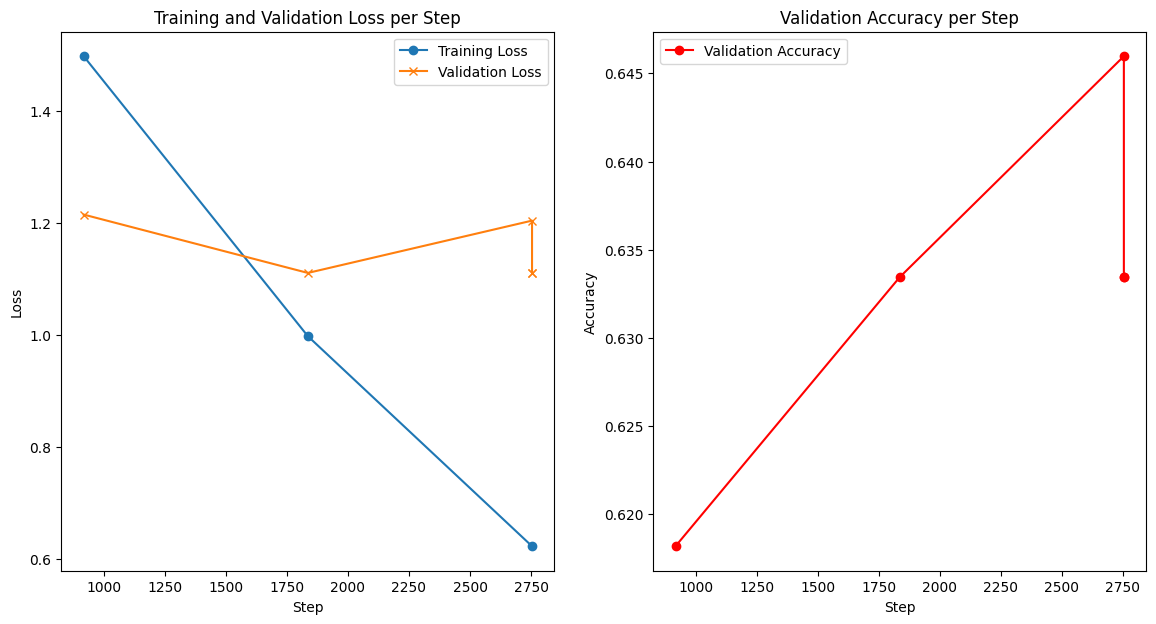

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot training loss and evaluation loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, training_loss, label='Training Loss', marker='o')
plt.plot(eval_steps, evaluation_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss per Step')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

# Plot evaluation accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_steps, train_accuracy, label='Validation Accuracy', color='r', marker='o')
plt.title('Validation Accuracy per Step')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       167
           1       0.50      0.52      0.51       128
           2       0.69      0.75      0.72       336
           3       0.48      0.47      0.48       232
           4       0.00      0.00      0.00        19
           5       0.70      0.75      0.72       571
           6       0.40      0.58      0.47        81
           7       0.76      0.61      0.68       153
           8       0.33      0.07      0.11        45
           9       0.54      0.35      0.42       104

    accuracy                           0.63      1836
   macro avg       0.51      0.48      0.49      1836
weighted avg       0.62      0.63      0.62      1836

